In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp

import utils
import qlearning
import replay

In [3]:
seed = 42
map_size = 4
max_interactions = 2**20
map_scale = int(jnp.log2(map_size))

# hyperparams
rollout_length = 8 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8
lr = 3e-4

q_learning_step = partial(
    qlearning.q_learning_step, rollout_length=rollout_length, train_iter=train_iter
)

In [4]:
# @partial(jax.jit, static_argnames=("map_size", "lr", "replay_capacity"))
def setup_simulation(rng_key, map_size, lr, replay_capacity):
    rng_env, rng_dql = jax.random.split(rng_key)
    env = utils.FrozenLake.make_random(rng_env, (map_size, map_size), 0.8)

    env_state, obs = env.reset(rng_key)
    action = env.action_space.sample(rng_key)
    sample_transition = utils.Transition(env_state, obs, action, 0.0, obs, False, {})

    qnet = utils.ConvNet(hidden=[2 * map_size] * int(np.log2(map_size)), out=4)
    dql_state = qlearning.DQLTrainState.create(rng_dql, qnet, obs, lr)
    replay_memory = replay.CircularBuffer.create(sample_transition, replay_capacity)
    return (env, dql_state, replay_memory)

In [5]:
rng_key = jax.random.PRNGKey(seed)
rng_init, rng_sim = jax.random.split(rng_key)
rng_sim = jax.random.split(rng_sim, n_rollouts)
(env, dql_state, replay_memory) = setup_simulation(rng_key, map_size, lr, replay_capacity=2**14)
(env, dql_state, replay_memory), results = jax.lax.scan(q_learning_step, (env, dql_state, replay_memory), rng_sim)

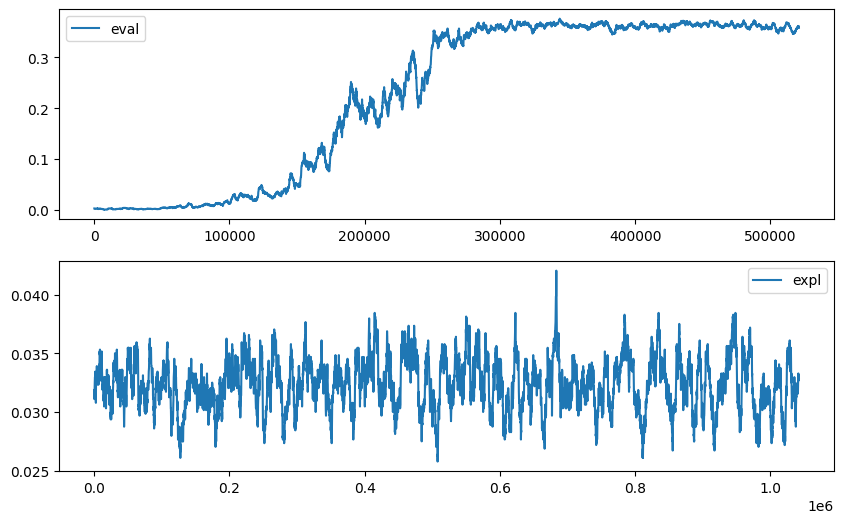

In [6]:
import matplotlib.pyplot as plt
import plotting


def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")


plt.figure(figsize=(10, 6))
plt.subplot(211)
r = smooth(results.eval_reward.mean(axis=-1))
plt.plot(results.eval_reward.shape[-1] * jnp.arange(1, 1 + len(r)), r, label="eval")
plt.legend()
plt.subplot(212)
r = smooth(results.expl_reward.mean(axis=-1))
plt.plot(results.expl_reward.shape[-1] * jnp.arange(1, 1 + len(r)), r, label="expl")
plt.legend()
plt.show()

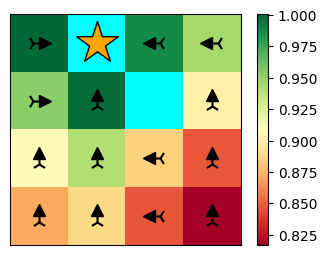

In [7]:
get_qval_fn = partial(dql_state.qval_apply_fn, dql_state.params_qnet)
plotting.plot_qvals(env, get_qval_fn)

In [8]:
%timeit jax.lax.scan(q_learning_step, (env, dql_state, replay_memory), rng_sim)[0][0].frozen.block_until_ready()

1min 53s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
